##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [401]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [402]:
orig_df = pd.read_csv('../../datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [403]:
df = pd.read_csv('../../datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [404]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [405]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [406]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [407]:
df.head()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0


In [408]:
df.columns

Index(['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time',
       'VictimCount'],
      dtype='object')

In our dataset, we have these columns :

    'X' (latitude)
    'Y' (longitude)
    'Time' (Hour of the day)
    'DayOfWeek' (Day of the week)
    'Area_Command' (Area-of-command code)
    'NIBRSOffenseCode' (Classification code for the crime committed)

They also happend to be our input.

Our target variable would be the last column VictimCount (Number of victims)

To check if we need to scale, shift or normalize our data, we will use the describe method:

In [409]:
df.describe()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,-115.159326,36.143360,3.978182,0.909091,2.981818,11.236364,0.712727
std,0.101294,0.118418,3.045799,0.334878,1.924590,7.039937,0.978427
min,-116.000000,35.068419,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-115.209198,36.114704,1.000000,1.000000,1.000000,5.000000,0.000000
50%,-115.149945,36.152415,3.000000,1.000000,3.000000,11.000000,0.000000
75%,-115.105200,36.183854,6.000000,1.000000,5.000000,18.000000,1.000000
max,-114.625570,37.000000,11.000000,2.000000,6.000000,23.000000,6.000000


It does not look like we need to make any transformation on our data.

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [410]:
X = torch.tensor(df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']].values, dtype=torch.float32)
y = torch.tensor(df['VictimCount'].values, dtype=torch.float32)

full_dataset = TensorDataset(X, y)

# Split the dataset into train and test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

batch_size = 64

# Create DataLoaders for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Let's verify th'e shape of our data
for batch in train_loader:
    X_batch, y_batch = batch
    print("Shape of X_batch:", X_batch.shape)
    print("Shape of y_batch:", y_batch.shape)
    break 


Shape of X_batch: torch.Size([64, 6])
Shape of y_batch: torch.Size([64])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

We will use MSE as loss function.


As it is a regression problem and we only want to predict the number of crime victims as a real number, our output should have 1 as size.


I tried using a simple model with almost no hidden layer, but as the results were not so great, i added a few layers and it turned out MSE lowered.


I also tried using 0.01 as learning rate and using SGD as optimizer, but i had better result using these final parameters:

We will use Adam as optimizer and 0.001 as learning rate.


In [411]:
#Let's define our regression model:

class Regression(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Regression, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

#Let's define our hyperparameters:
input_size = 6
output_size = 1
hidden_size = 64

model = Regression(input_size, hidden_size, output_size)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Let's train our model
num_epochs = 10

for epoch in range(num_epochs):

    model.train()

    for X_train, y_train in train_loader:
        optimizer.zero_grad()
        output = model(X_train)
        loss = loss_function(output, y_train)
        loss.backward()
        optimizer.step()

    model.eval()

    with torch.no_grad():
        test_loss = 0
        for X_test, y_test in test_loader:
            test_output = model(X_test)
            test_loss += loss_function(test_output, y_test)


    print(f"Epoch {epoch + 1}->{num_epochs} | MSE : {test_loss}")


Epoch 1->10 | MSE : 2.2946348190307617
Epoch 2->10 | MSE : 1.6176365613937378
Epoch 3->10 | MSE : 0.9264078736305237
Epoch 4->10 | MSE : 1.1579893827438354
Epoch 5->10 | MSE : 1.2746950387954712
Epoch 6->10 | MSE : 1.041954755783081


c:\Users\Chloé\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Chloé\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Chloé\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incor

Epoch 7->10 | MSE : 0.8672434091567993
Epoch 8->10 | MSE : 0.9400821328163147
Epoch 9->10 | MSE : 0.9902135729789734
Epoch 10->10 | MSE : 0.9344565272331238


## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [412]:
X = torch.tensor(df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']].values, dtype=torch.float32)
y = torch.tensor(df['VictimCount'].values, dtype=torch.float32)

#Let's define a function to map the number of crime victims to specific classes
#We will use class 0 for count number of crime victims from 0 to 1, 
#            class 1 from 2 to 4
#            class 2 from 5 to 10
#            class 3 for more than 10.


def mappingClass(victims):
    if 0 <= victims <= 1:
        return 0
    elif 2 <= victims <= 4:
        return 1
    elif 5 <= victims <= 10:
        return 2
    else:
        return 3
    
classNumber = np.array([mappingClass(victims) for victims in y])
classNumber

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0])

In [417]:
# Let's define our classification model
class Classification(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Classification, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(classNumber, dtype= torch.long)

full_dataset = TensorDataset(X_tensor, Y_tensor)

# Define train and test sizes
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# Using the same batch size as before
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_size = 6  # Number of input we defined in task 1
hidden_size = 64 
num_classes = 4  # Number of classes we defined above
model = Classification(input_size, hidden_size, num_classes)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training and testing loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for X_train, y_train in train_loader:
        optimizer.zero_grad()
        output = model(X_train)
        loss = loss_function(output, y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for X_test, y_test in test_loader:
            test_output = model(X_test)
            loss = loss_function(test_output, y_test)
            test_loss += loss.item()


    print(f"Epoch {epoch + 1}->{num_epochs} | MSE : {test_loss}")


C:\Users\Chloé\AppData\Local\Temp\ipykernel_17784\3315233693.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


Epoch 1->20 | MSE : 11.169882774353027
Epoch 2->20 | MSE : 5.081475257873535
Epoch 3->20 | MSE : 0.8348516225814819
Epoch 4->20 | MSE : 1.0786715745925903
Epoch 5->20 | MSE : 1.3376601934432983
Epoch 6->20 | MSE : 1.4603240489959717
Epoch 7->20 | MSE : 1.4807285070419312
Epoch 8->20 | MSE : 1.4133634567260742
Epoch 9->20 | MSE : 1.2972544431686401
Epoch 10->20 | MSE : 1.1452616453170776
Epoch 11->20 | MSE : 0.9658159017562866
Epoch 12->20 | MSE : 0.7749047875404358
Epoch 13->20 | MSE : 0.6163673400878906
Epoch 14->20 | MSE : 0.5721277594566345
Epoch 15->20 | MSE : 0.6352128386497498
Epoch 16->20 | MSE : 0.580105185508728
Epoch 17->20 | MSE : 0.5073838233947754
Epoch 18->20 | MSE : 0.4922470152378082
Epoch 19->20 | MSE : 0.47724831104278564
Epoch 20->20 | MSE : 0.44694748520851135


## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

I had pretty much no problem making a Regression model that worked out, but it was way harder with classification, since we had to change our one size output into a class to make it work out.

Looking at our MSE, it looks like our Classification model worked better than our regression mode, which might be due to the fact that there is a large range of numerical values for our victim counts.

I used AI assistance when coding Classification, especially regarding the mapping class because i could not think of doing it though it is quite logical; but also for the miss-classification code below.

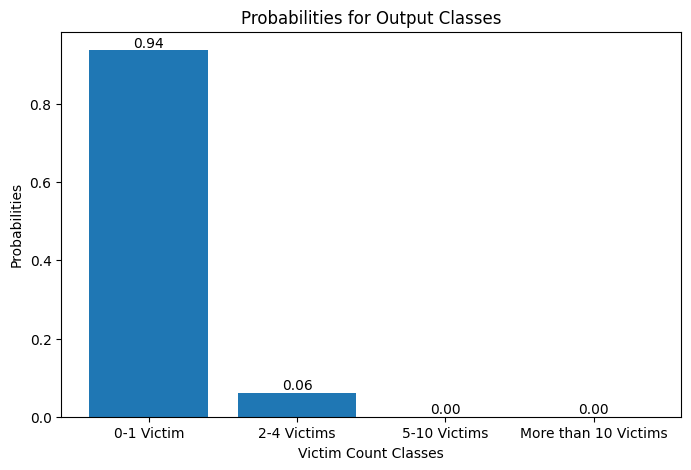

Missclassified Example - Correct Label: 1, Predicted Label: 0


In [414]:
model.eval()
missed_example = None
correct_label = None
predicted_label = None

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(predicted)):
            if predicted[i] != labels[i]:
                missed_example = inputs[i]
                correct_label = labels[i]
                predicted_label = predicted[i]
                break

# Calculating probability
probabilities = torch.softmax(model(missed_example), dim=0).detach().numpy()

# Plotting bar chart
plt.figure(figsize=(8, 5))
classes = ['0-1 Victim', '2-4 Victims', '5-10 Victims', 'More than 10 Victims']
bar_plot = plt.bar(classes, probabilities)
plt.xlabel('Victim Count Classes')
plt.ylabel('Probabilities')
plt.title('Probabilities for Output Classes')

# Adding probability values on top of each bar
for i, bar in enumerate(bar_plot):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{probabilities[i]:.2f}', 
             ha='center', va='bottom')

plt.show()

print(f'Missclassified Example - Correct Label: {correct_label}, Predicted Label: {predicted_label}')


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


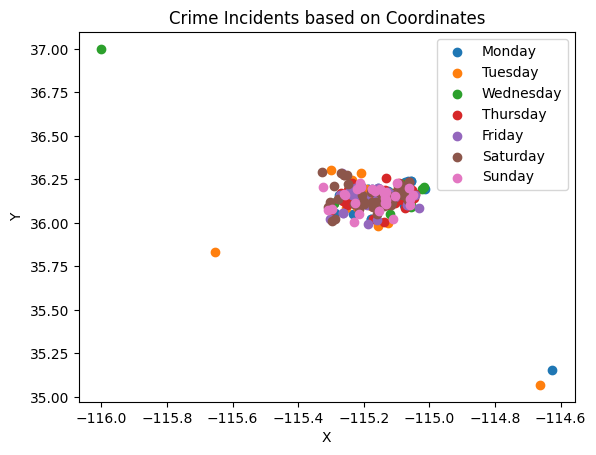

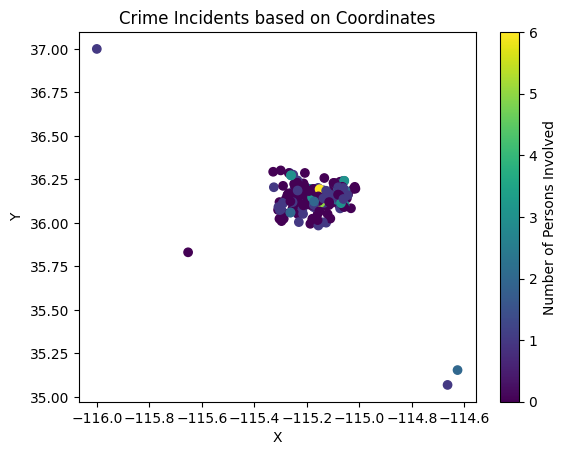

DayOfWeek
4    51
3    44
5    43
0    40
1    37
2    32
6    28
Name: count, dtype: int64


In [415]:
day_mapping = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

for day in df['DayOfWeek'].unique():
    plt.scatter(df[df['DayOfWeek'] == day]['X'], df[df['DayOfWeek'] == day]['Y'], label=day_mapping[day])

plt.title('Crime Incidents based on Coordinates')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

plt.scatter(df['X'], df['Y'], c=df['VictimCount'])
plt.colorbar(label='Number of Persons Involved')
plt.title('Crime Incidents based on Coordinates')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Using numpy (or pandas) to sort the number of crimes reported by day of the week
crimes_by_day = df['DayOfWeek'].value_counts().sort_values(ascending=False)
print(crimes_by_day)


Both plots are higlighting a cluster in a certain area. It looks like there are a lots of pink and brown dots, which correspond to the sunday and saturday, and it also looks like the majority of crime incidents involve 1 person at most since purple is a dominent color.